In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report

In [2]:
def load_unsw_nb15(train_file, test_file):
    # Load training and testing datasets
    train_data = pd.read_parquet(train_file)
    test_data = pd.read_parquet(test_file)
    test_data.drop(columns=['label'] ,inplace=True)
    train_data.drop(columns=['label'] ,inplace=True)
    # Separate features and labels
    X_train = train_data.iloc[:, :-1]
    y_train = train_data.iloc[:, -1]
    X_test = test_data.iloc[:, :-1]
    y_test = test_data.iloc[:, -1]

    # Combine training and testing data for consistent encoding
    X_combined = pd.concat([X_train, X_test])
    X_combined.drop(columns=['spkts','sbytes','dpkts','dbytes','swin','tcprtt','sinpkt','ct_dst_sport_ltm','is_ftp_login'] ,inplace=True)

    # One-hot encode categorical features using pd.get_dummies
    X_combined = pd.get_dummies(X_combined, drop_first=False)

    # Normalize numerical features (all columns after encoding)
    scaler = MinMaxScaler()
    X_combined_scaled = scaler.fit_transform(X_combined)

    # Split back into training and testing sets
    X_train_processed = X_combined_scaled[:len(X_train)]
    X_test_processed = X_combined_scaled[len(X_train):]

    # One-hot encode labels
    label_encoder = OneHotEncoder(sparse_output=False)
    y_train_encoded = label_encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_test_encoded = label_encoder.transform(y_test.values.reshape(-1, 1))

    return X_train_processed, y_train_encoded, X_test_processed, y_test_encoded, y_train_encoded.shape[1]

In [3]:
def contractive_loss(inputs, outputs, encoder, lambda_c):

    # Ensure inputs are Tensors of type float32
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    outputs = tf.convert_to_tensor(outputs, dtype=tf.float32)

    # Mean Squared Error Loss
    mse_loss = tf.reduce_mean(tf.square(inputs - outputs))

    # Contractive Penalty
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        encoded_output = encoder(inputs)
        jacobian = tape.gradient(encoded_output, inputs)
        contractive_penalty = lambda_c * tf.reduce_sum(tf.square(jacobian))

    # Combine losses
    return tf.add(mse_loss, contractive_penalty)  # Explicitly ensure compatibility with tf.float32



In [4]:
def train_stacked_autoencoder(input_dim, X_train, layer_sizes=[128, 72, 30], epochs=8, batch_size=32, lambda_c=1e-4):
    current_input = X_train
    encoders = []
    decoders = []  # Store decoders for each layer
    
    for idx, layer_size in enumerate(layer_sizes):
        print(f"Training layer {idx + 1} with {layer_size} neurons...")
        
        # Define the autoencoder with both encoder and decoder
        input_layer = layers.Input(shape=(current_input.shape[1],))
        
        # Encoder
        encoded = layers.Dense(layer_size, activation='sigmoid', name=f'encoder_{idx}')(input_layer)
        
        # Decoder
        decoded = layers.Dense(current_input.shape[1], activation='sigmoid', name=f'decoder_{idx}')(encoded)
        
        # Full autoencoder model
        autoencoder = models.Model(inputs=input_layer, outputs=decoded)
        
        # Separate encoder and decoder models
        encoder = models.Model(inputs=input_layer, outputs=encoded)
        decoder = models.Model(inputs=encoded, outputs=decoded)
        
        # Optimizer and training setup
        optimizer = Adam(learning_rate=0.001)
        
        for epoch in range(epochs):
            epoch_loss = 0.0
            num_batches = 0
            print(f"Epoch {epoch + 1}/{epochs}")
            
            for i in range(0, current_input.shape[0], batch_size):
                X_batch = current_input[i:i + batch_size]
                
                with tf.GradientTape() as tape:
                    reconstructed = autoencoder(X_batch)
                    loss = contractive_loss(
                        inputs=X_batch,
                        outputs=reconstructed,
                        encoder=encoder,
                        lambda_c=lambda_c
                    )
                
                grads = tape.gradient(loss, autoencoder.trainable_weights)
                optimizer.apply_gradients(zip(grads, autoencoder.trainable_weights))
                
                epoch_loss += loss.numpy()
                num_batches += 1
            
            avg_loss = epoch_loss / num_batches
            print(f"  Loss: {avg_loss:.6f}")
        
        # Freeze the encoder and decoder weights
        for layer in encoder.layers:
            layer.trainable = False
        for layer in decoder.layers:
            layer.trainable = False
        
        # Save the trained encoder and decoder
        encoders.append(encoder)
        decoders.append(decoder)
        
        # Update input for the next layer
        current_input = encoder(current_input)
    
    return encoders, decoders

In [5]:
import matplotlib.pyplot as plt
def diagnose_autoencoder(encoders, decoders, X_train, X_test):
    plt.figure(figsize=(20, 10))
    current_input_train = X_train
    current_input_test = X_test
    
    for idx, (encoder, decoder) in enumerate(zip(encoders, decoders)):
        # Encode data for the current layer
        X_train_encoded = encoder(current_input_train)
        X_test_encoded = encoder(current_input_test)
        
        # Decode data to compute reconstruction error
        X_train_reconstructed = decoder(X_train_encoded)
        
        # Compute reconstruction error
        recon_error = np.mean(np.square(current_input_train - X_train_reconstructed), axis=1)
        
        # Visualization
        plt.subplot(2, len(encoders), idx + 1)
        plt.title(f'Layer {idx + 1} Reconstruction Error Distribution')
        plt.hist(recon_error, bins=50)
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Frequency')
        
        # Sample reconstructions
        plt.subplot(2, len(encoders), len(encoders) + idx + 1)
        plt.title(f'Layer {idx + 1} Sample Reconstructions')
        sample_indices = np.random.choice(len(current_input_train), 5, replace=False)
        for i, sample_idx in enumerate(sample_indices):
            plt.plot(current_input_train[sample_idx], 'b-', label='Original' if i == 0 else None)
            plt.plot(X_train_reconstructed[sample_idx], 'r--', label='Reconstructed' if i == 0 else None)
        plt.legend()
        
        # Update input for the next layer
        current_input_train = X_train_encoded
        current_input_test = X_test_encoded
    
    plt.tight_layout()
    plt.show()


In [6]:
def print_model_parameters(model):
    print(f"{'Layer Name':<40}{'Output Shape':<30}{'Param #':<15}")
    print("="*85)
    total_params = 0
    for layer in model.layers:
        layer_params = layer.count_params()  # Number of trainable + non-trainable params
        if hasattr(layer, "output_shape"):  # Check if the layer has an output_shape attribute
            output_shape = str(layer.output_shape)
        else:
            output_shape = "N/A"  # Use N/A for layers like InputLayer
        
        if layer.trainable:
            print(f"{layer.name:<40}{output_shape:<30}{layer_params:<15}")
            total_params += layer_params
        else:
            print(f"{layer.name:<40}{output_shape:<30}{'Non-trainable':<15}")
    print("="*85)
    print(f"Total Trainable Parameters: {total_params}")



Training layer 1 with 128 neurons...
Epoch 1/8
  Loss: 0.003506
Epoch 2/8
  Loss: 0.000792
Epoch 3/8
  Loss: 0.000553
Epoch 4/8
  Loss: 0.000497
Epoch 5/8
  Loss: 0.000481
Epoch 6/8
  Loss: 0.000474
Epoch 7/8
  Loss: 0.000470
Epoch 8/8
  Loss: 0.000467
Training layer 2 with 72 neurons...
Epoch 1/8
  Loss: 0.002645
Epoch 2/8
  Loss: 0.000215
Epoch 3/8
  Loss: 0.000085
Epoch 4/8
  Loss: 0.000051
Epoch 5/8
  Loss: 0.000036
Epoch 6/8
  Loss: 0.000029
Epoch 7/8
  Loss: 0.000025
Epoch 8/8
  Loss: 0.000022
Training layer 3 with 30 neurons...
Epoch 1/8
  Loss: 0.004874
Epoch 2/8
  Loss: 0.000585
Epoch 3/8
  Loss: 0.000200
Epoch 4/8
  Loss: 0.000110
Epoch 5/8
  Loss: 0.000069
Epoch 6/8
  Loss: 0.000049
Epoch 7/8
  Loss: 0.000038
Epoch 8/8
  Loss: 0.000030


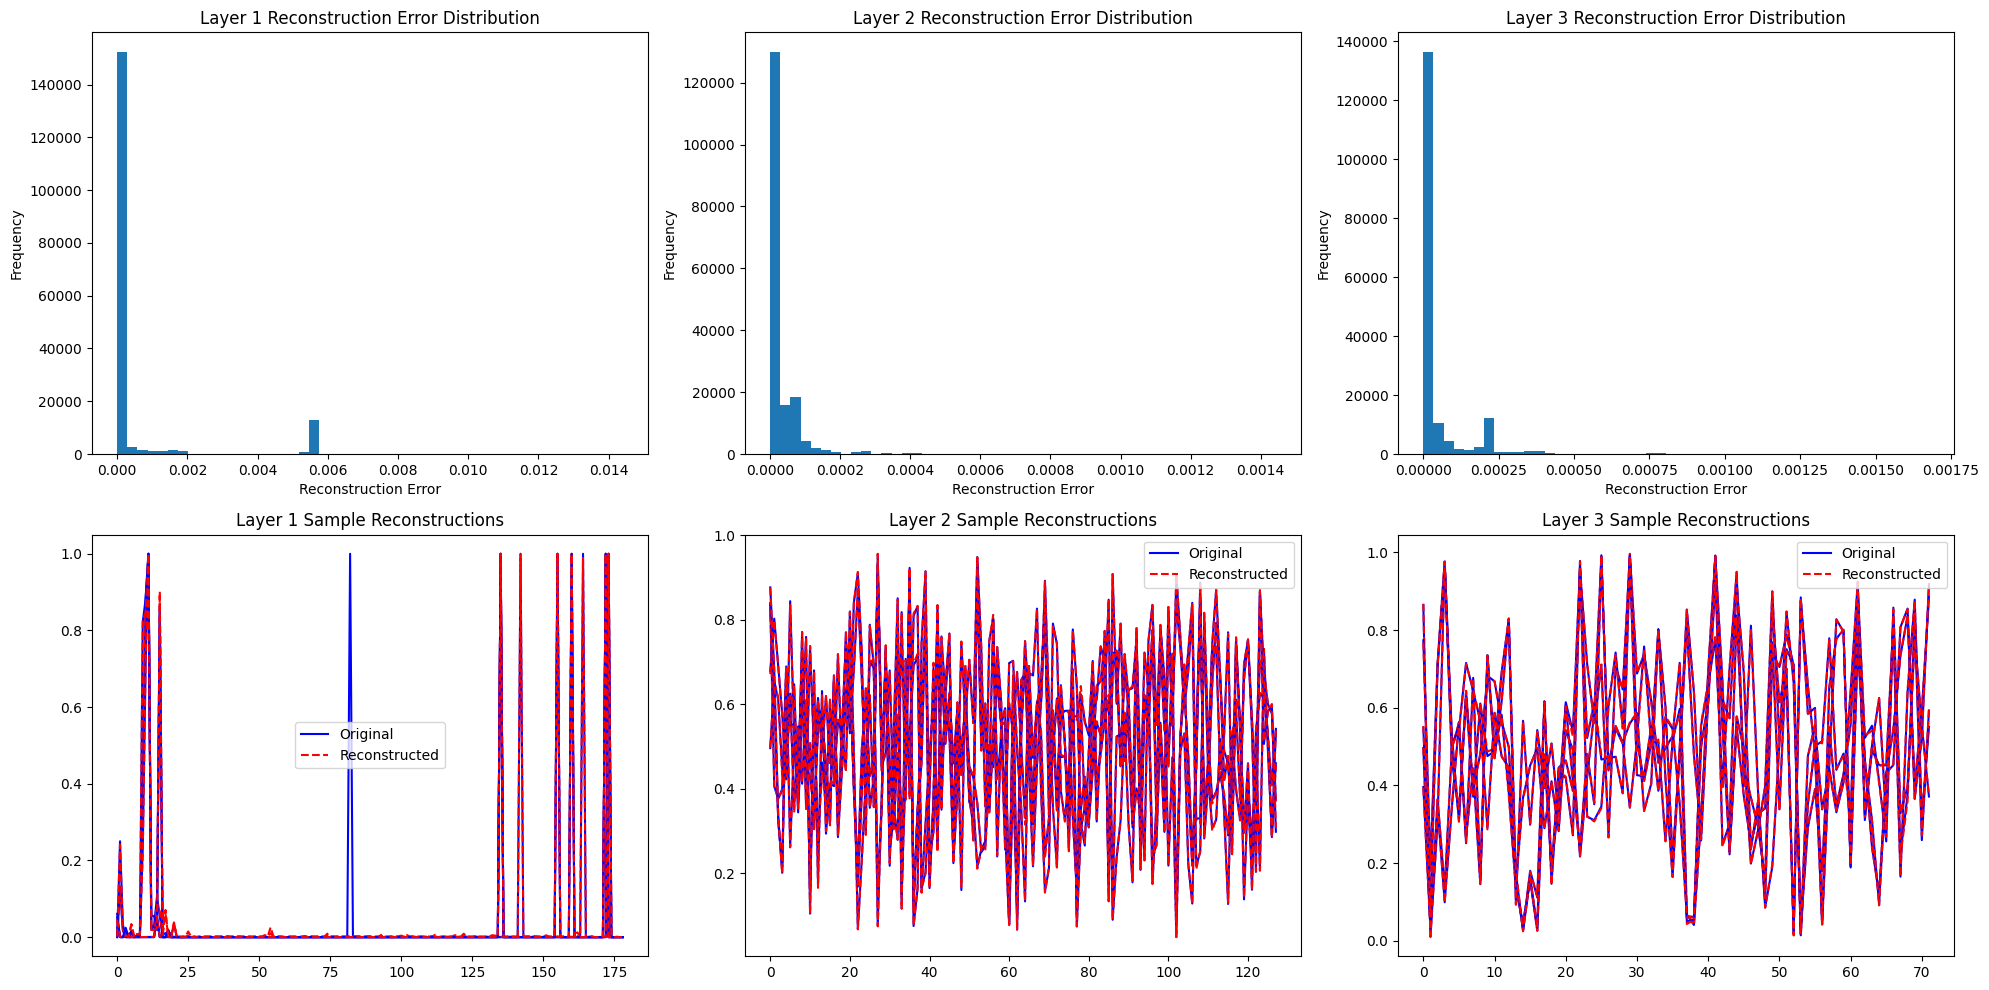

Epoch 1/50
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6437 - loss: 0.9582 - val_accuracy: 0.6264 - val_loss: 0.8418
Epoch 2/50
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7052 - loss: 0.7418 - val_accuracy: 0.6428 - val_loss: 0.8072
Epoch 3/50
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7217 - loss: 0.6998 - val_accuracy: 0.7149 - val_loss: 0.7147
Epoch 4/50
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7307 - loss: 0.6748 - val_accuracy: 0.6634 - val_loss: 0.7539
Epoch 5/50
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7372 - loss: 0.6599 - val_accuracy: 0.6759 - val_loss: 0.7401
Epoch 6/50
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7372 - loss: 0.6540 - val_accuracy: 0.6671 - val_loss: 0.7805
Epoch 7/50
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7423 - loss: 0.6489 - val_accuracy: 0.6622 - val_loss: 0.7898
Epoch 8/50
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7437 - loss: 0

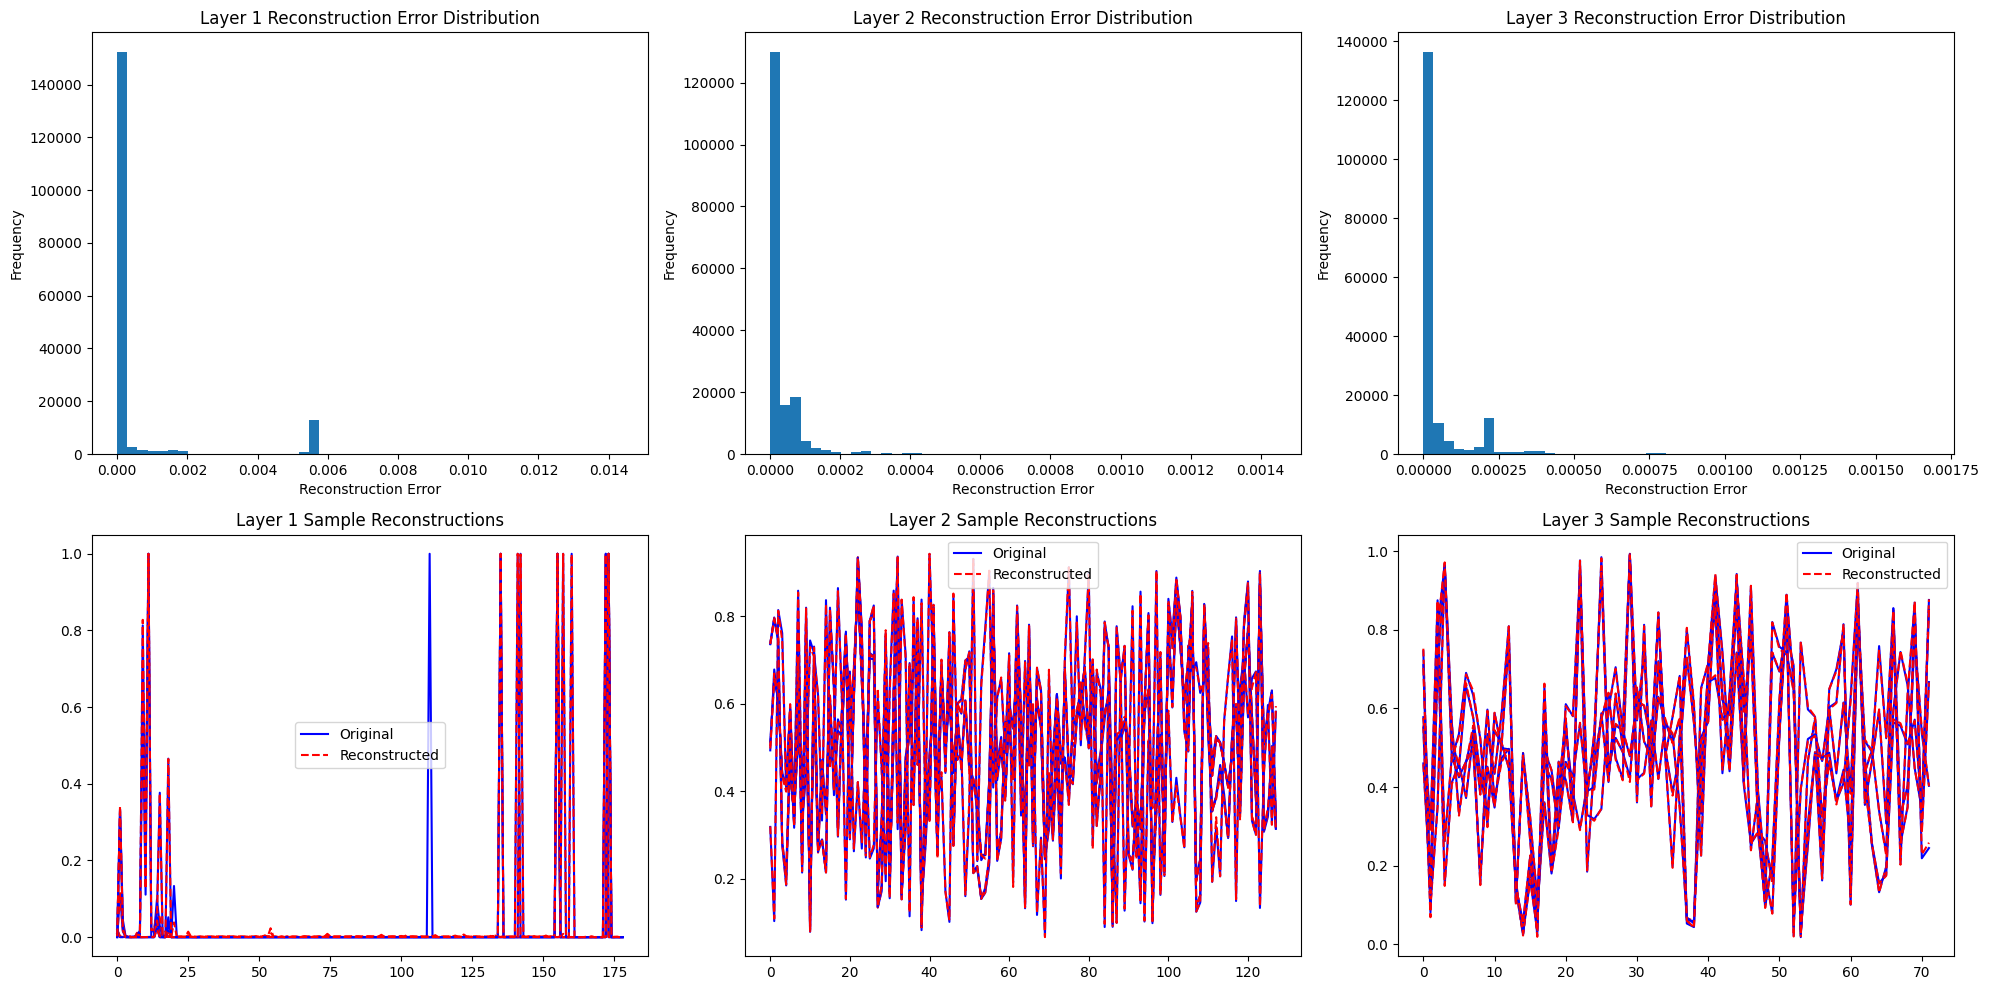

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.31      0.01      0.02       583
           2       0.47      0.01      0.02      4089
           3       0.49      0.80      0.61     11132
           4       0.27      0.50      0.35      6062
           5       1.00      0.96      0.98     18871
           6       0.93      0.67      0.78     37000
           7       0.39      0.85      0.53      3496
           8       0.42      0.25      0.31       378
           9       0.00      0.00      0.00        44

    accuracy                           0.70     82332
   macro avg       0.43      0.40      0.36     82332
weighted avg       0.78      0.70      0.71     82332



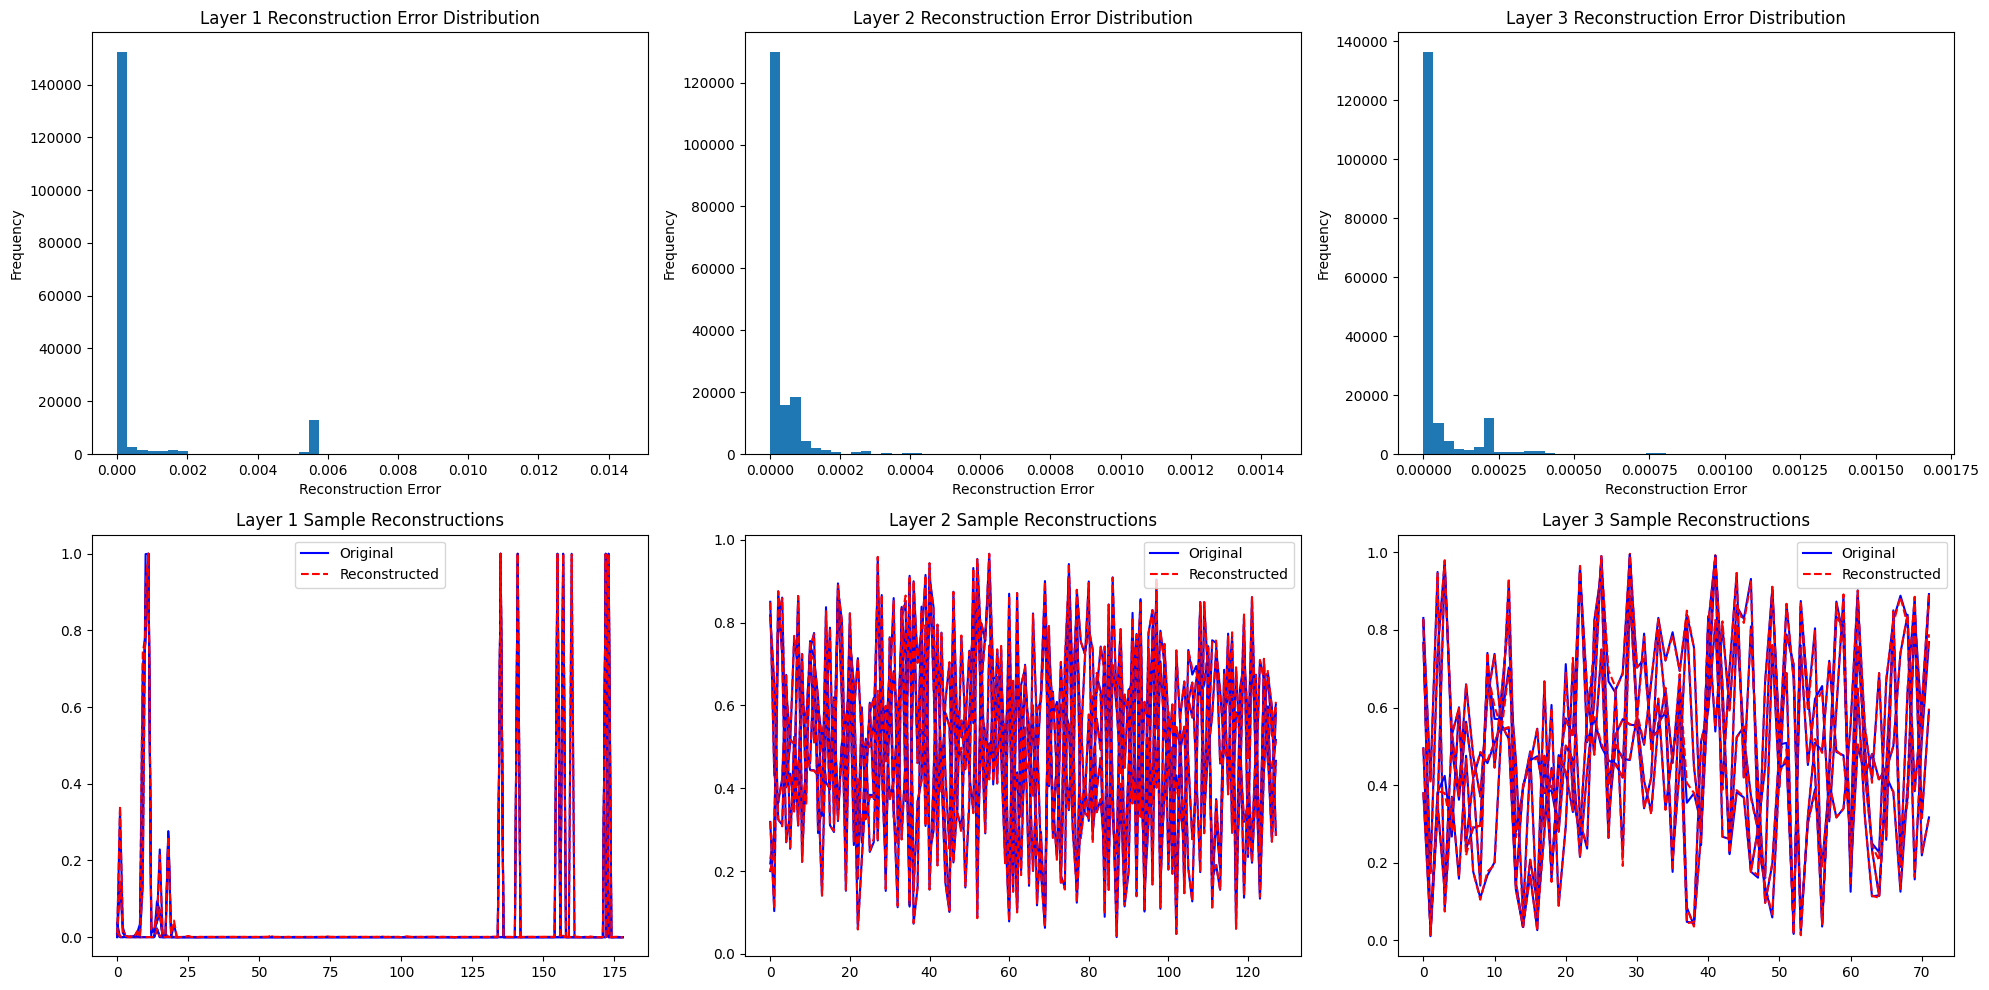

Layer Name                              Output Shape                  Param #        
input_layer_3                           N/A                           0              
functional_1                            (None, 128)                   23040          
functional_4                            (None, 72)                    9288           
functional_7                            (None, 30)                    2190           
reshape                                 N/A                           0              
conv1d                                  N/A                           128            
conv1d_1                                N/A                           128            
multiply                                N/A                           0              
flatten                                 N/A                           0              
dense                                   N/A                           61504          
dense_1                                 N/A           

In [7]:
# Build and train full integrated model
def build_and_train_full_model(encoders, X_train, y_train, X_test, y_test, input_dim, num_classes, epochs=50, batch_size=32):
    # Input layer
    input_layer = layers.Input(shape=(input_dim,))

    # Apply each encoder sequentially
    encoded_features = input_layer
    for encoder in encoders:
        encoded_features = encoder(encoded_features)

    # Reshape for convolutional layers
    reshaped = layers.Reshape((encoded_features.shape[1], 1))(encoded_features)

    # Gated convolution
    conv_a = layers.Conv1D(32, kernel_size=3, padding='same', activation=None)(reshaped)
    conv_b = layers.Conv1D(32, kernel_size=3, padding='same', activation='sigmoid')(reshaped)
    gated_output = layers.multiply([conv_a, conv_b])

    # Flatten and ANN for classification
    flattened = layers.Flatten()(gated_output)
    dense1 = layers.Dense(64, activation='relu')(flattened)
    dense2 = layers.Dense(32, activation='relu')(dense1)
    output_layer = layers.Dense(num_classes, activation='softmax')(dense2)

    # Full model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model on the entire training set and validate on the testing set
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

    return model


# Train and evaluate the model
def train_and_evaluate_modified(train_file, test_file):
    # Load and preprocess data
    X_train, y_train, X_test, y_test, num_classes = load_unsw_nb15(train_file, test_file)

    # Train stacked autoencoder one layer at a time
    input_dim = X_train.shape[1]
    encoders, decoders = train_stacked_autoencoder(input_dim, X_train)
    diagnose_autoencoder(encoders, decoders, X_train, X_test)

    # Build and train the full model with integrated Gated CNN and ANN
    model = build_and_train_full_model(encoders, X_train, y_train,X_test, y_test, input_dim, num_classes)
    diagnose_autoencoder(encoders, decoders, X_train, X_test)

    # Evaluate model
    predictions = np.argmax(model.predict(X_test), axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    print(classification_report(y_test_labels, predictions))
    diagnose_autoencoder(encoders, decoders, X_train, X_test)
    return model

# Main script
if __name__ == "__main__":
    train_file = "/kaggle/input/unswnb15/UNSW_NB15_training-set.parquet"  # Replace with actual file path
    test_file = "/kaggle/input/unswnb15/UNSW_NB15_testing-set.parquet"    # Replace with actual file path
    model=train_and_evaluate_modified(train_file, test_file)
    print_model_parameters(model)
